# Homework
## Preparing the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [4]:
feature_cols = [
	'engine_displacement',
	'horsepower',
	'vehicle_weight',
	'model_year',
	'fuel_efficiency_mpg'
]
df = df.loc[:, feature_cols]

## EDA

In [5]:
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


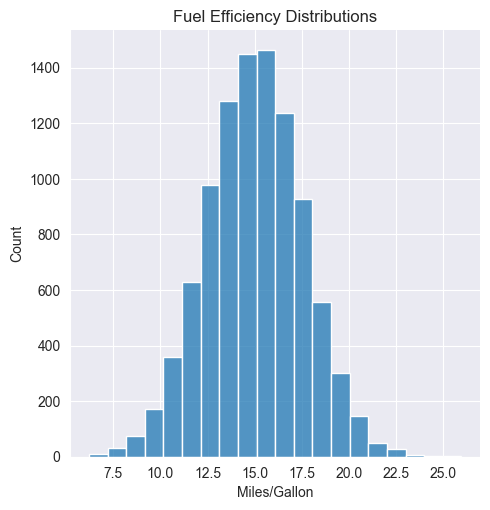

In [6]:
sns.displot(df, x="fuel_efficiency_mpg", bins=20)
plt.title("Fuel Efficiency Distributions")
plt.xlabel("Miles/Gallon")
plt.show()

> The `fuel_efficiency_mpg` does not show significant skew

### Question 1
There's one column with missing values. What is it?

In [7]:
print("Columns with missing values:", list(df.columns[df.isna().sum() > 0]))

Columns with missing values: ['horsepower']


### Q2. Records count
What's the median (50% percentile) for variable 'horsepower'?

In [8]:
print("Median of the 'horsepower' variable: ", df.horsepower.median())

Median of the 'horsepower' variable:  149.0


## Splitting the dataset

In [9]:
# apply 60%/20%/20% split
n = df.shape[0]

n_val = n_test = int(n * .2)
n_train = n - (n_val + n_test)

In [10]:
idx = np.arange(n)
np.random.shuffle(idx)

In [11]:
df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train + n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train + n_val:]].reset_index(drop=True)

In [12]:
assert df_val.shape == df_test.shape

### Question 4